# **Dice number classification algorithm**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV
from sklearn.externals import joblib

#import generateDataset as db

# Read database

Functions used to read the database (train and test) from MNIST and also from the csv file generated with the images captured from the pico camera

In [2]:
def separate_array(data):    
    image = []
    labels = []
    for line in data:
        image.append(np.array(line[:-1]))
        labels.append(line[-1])
    
    return image, labels

In [3]:
X_train, Y_train = separate_array(np.load('./../photosFeatures_train.npy'))

In [6]:
X_validation, Y_validation = separate_array(np.load('./../photosFeatures_validation.npy'))

In [12]:
print len(Y_validation)
print len(Y_train)

10368
41472


# **Evaluation methods**

This part contains the functions used to analyse the accuracy of the classifier

In [13]:
def plot_confusion_matrix(clf, data_x, data_y):
    classes = range(1,7)
    
    Ypred = clf.predict(data_x)
    
    # Computation of confusion matrix on testing set
    cm = confusion_matrix(data_y, Ypred)
    
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# **KK Neighborhod algorithm**

In [14]:
def create_number_list(data):
    images = []
    for x in data:
        images.append(x.reshape(-1))

    return images

In [15]:
def train_knn_Model(i, X_data, Y_data):
    # Train on the train images
    train_x = create_number_list(X_data)
    train_y = np.array(Y_data)
    
    #Train the classifier
    clf = KNeighborsClassifier(n_neighbors = i)
    print("Finished trainning KNN Model with " + str(i) + " neighbors")
    
    return clf.fit(train_x, train_y)

In [16]:
def visualize_knn_Model(clf, X_data, Y_data, filename, typeData):
    # Visualize on the images from dataset:
    data_x = create_number_list(X_data)
    data_y = Y_data 
    predicted = clf.predict(data_x)
    
    plot_confusion_matrix(clf, data_x, data_y)
    plt.title(typeData + ' confusion matrix: accuracy of ' + str(round((accuracy_score(data_y, predicted) * 100), 3)) + "% \n Used " + str(len(data_x)) + " images")
    plt.savefig(filename)

In [33]:
knn_classifier = train_knn_Model(6, X_train, Y_train)

Finished trainning KNN Model with 6 neighbors


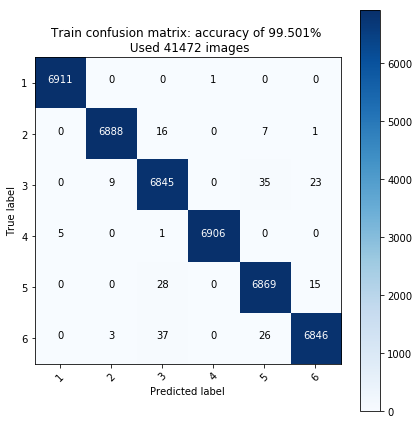

In [34]:
visualize_knn_Model(knn_classifier, X_train, Y_train,'./Results/knn/train', 'Train')

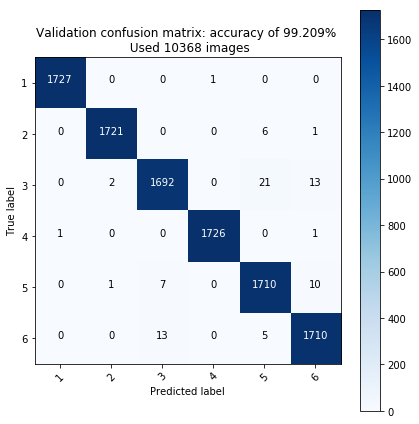

In [35]:
visualize_knn_Model(knn_classifier, X_validation, Y_validation,'./Results/knn/validation', 'Validation')

In [24]:
# save the classifier
filename = './Results/knn/knn_classifier.sav'
joblib.dump(knn_classifier, filename, compress = 3)  

['./Results/knn/knn_classifier.sav']

# **Multiple Hyperparameter Study**
This part consist in making a study of the hyperparameter of the classifier, using the gridsearch method from the scikitlearn library.

In [13]:
# Define the parameter values that should be searched
k_range = list(range(2, 15))

# Another parameter besides k that we might vary is the weights parameters or even the algorithm
weight_options = ['uniform', 'distance']
#algorithm_options = ['auto', 'ball_tree', 'kd_tree', 'brute']

# Specify "parameter grid"
grid_parameters = dict(n_neighbors=k_range, weights=weight_options)

# Specify "parameter distributions" rather than a "parameter grid"
dist_parameters = dict(n_neighbors=k_range, weights=weight_options)

# Since both parameters are discrete, so param_dist is the same as param_grid

# Finally define the classifier, in this case the KNN classifier
new_knn = KNeighborsClassifier()

In [14]:
# This block is done both grid and random search for the hyperparameters for N numbers
def compute_best_classifier(X_data, Y_data, param_grid, param_dist, model):
    grid_best_scores = []
    grid_best_params = []
    grid_best_estimator = []

    rand_best_scores = []
    rand_best_params = []
    rand_best_estimator = []

    train_x = create_number_list(X_data)
    train_y = np.array(Y_data)

    for i in list(range(15)):
        print("Iteration num: " + str(i))
        grid = GridSearchCV(model, param_grid, cv=10, scoring='accuracy', n_jobs = -1)
        grid.fit(train_x, train_y)
        grid_best_scores.append(grid.best_score_)
        grid_best_params.append(grid.best_params_)
        grid_best_estimator.append(grid.best_estimator_)

        rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10, n_jobs = -1)
        rand.fit(train_x, train_y)
        rand_best_scores.append(rand.best_score_)
        rand_best_params.append(rand.best_params_)
        rand_best_estimator.append(rand.best_estimator_)

    print("Finished searching the hyper parameters!")
    
    # This block draw accuracies of the differents classifiers used in the grid and random search

    plt.figure(figsize=(16, 8))
    plt.title("Final search results")   
    plt.plot(range(len(grid_best_scores)), grid_best_scores, label = 'Exaustive grid')
    plt.plot(range(len(rand_best_scores)), rand_best_scores, label = 'Random grid')
    plt.xlabel('Number of classifier')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(range(len(grid_best_scores)))
    plt.savefig('./Results/knn/tuningParameters')
    #plt.show()

    print("GRID SEARCH RESULTS")
    print("The best accuracy is: " + str(np.max(grid_best_scores) * 100) + "%")
    print("The parameters is: " + str(grid_best_params[np.argmax(grid_best_scores)]))
    print('\n')
    print("RANDOMGRID SEARCH RESULTS")
    print("The best accuracy is: " + str(np.max(rand_best_scores) * 100) + "%")
    print("The parameters is: " + str(rand_best_params[np.argmax(rand_best_scores)]))

    return rand_best_estimator[np.argmax(rand_best_scores)]

# BEST KNN Classifier + Photos Test

In [15]:
#Train the best classificator for a N sample of numbers
def train_best_classifier(X_data, Y_data, grid_par, dist_par, model):   
    classificator = compute_best_classifier(X_data, Y_data, grid_par, dist_par, model)

    return classificator.fit(X_data, Y_data)

Iteration num: 0
Iteration num: 1
Iteration num: 2
Iteration num: 3
Iteration num: 4
Iteration num: 5
Iteration num: 6
Iteration num: 7
Iteration num: 8
Iteration num: 9
Iteration num: 10
Iteration num: 11
Iteration num: 12
Iteration num: 13
Iteration num: 14
Finished searching the hyper parameters!
GRID SEARCH RESULTS
The best accuracy is: 74.10294481563969%
The parameters is: {'n_neighbors': 12, 'weights': 'distance'}


RANDOMGRID SEARCH RESULTS
The best accuracy is: 74.10294481563969%
The parameters is: {'n_neighbors': 12, 'weights': 'distance'}
CPU times: user 2h 16min 50s, sys: 2min 56s, total: 2h 19min 46s
Wall time: 3h 5min 50s


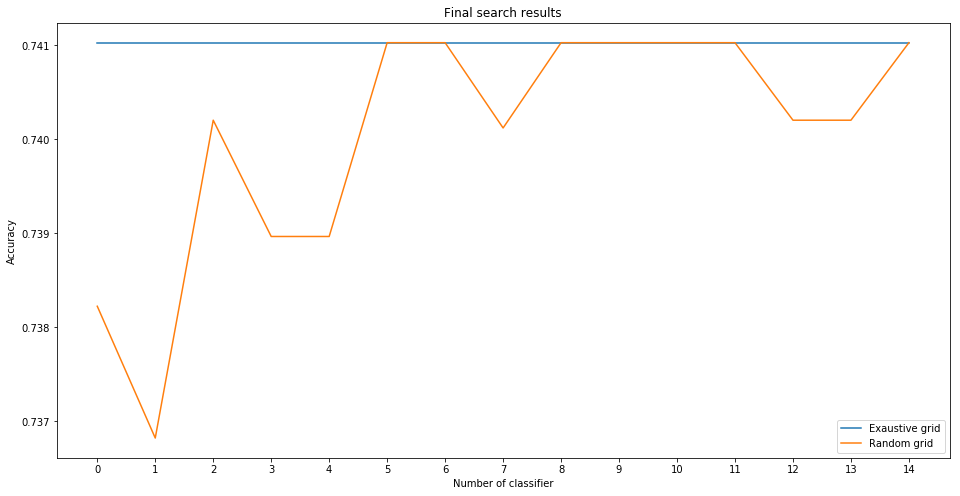

In [16]:
%%time 

best_knn_classifier = train_best_classifier(X_train, Y_train, grid_parameters, dist_parameters, new_knn)


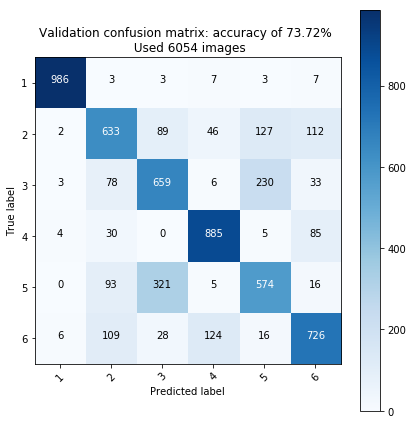

In [17]:
visualize_knn_Model(best_knn_classifier, X_validation, Y_validation,'./Results/knn/best_validation', 'Validation')

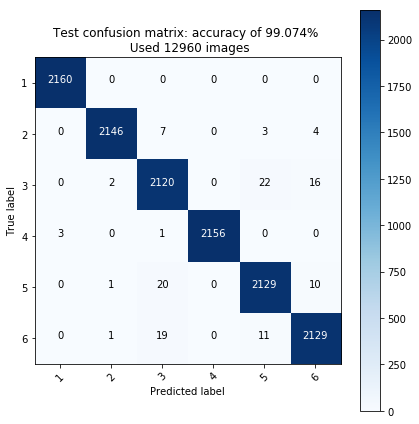

In [26]:
X_test, Y_test = separate_array(np.load('./../photosFeatures_test.npy'))
visualize_knn_Model(best_knn_classifier, X_test, Y_test,'./Results/knn/test', 'Test')

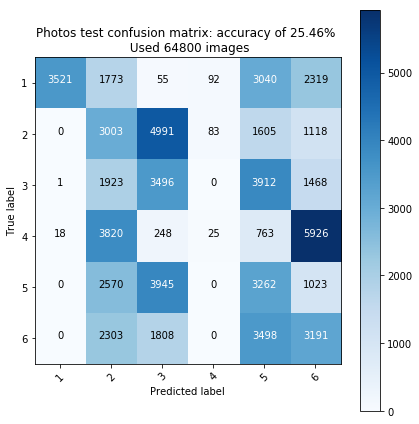

In [19]:
X_photos_test, Y_photos_test = separate_array(np.load('./test_photos_classes.npy'))
visualize_knn_Model(best_knn_classifier, X_photos_test, Y_photos_test,'./Results/knn/photos_test', 'Photos test')

In [20]:
# save the classifier
filename = './Results/knn/best_knn_classifier.sav'
joblib.dump(best_knn_classifier, filename, compress = 3)  

['./Results/knn/best_knn_classifier.sav']